In [1]:
# Simulate daily observations of a quasar for a year
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astroML.time_series import generate_damped_RW
t = np.arange(0,365)
y = generate_damped_RW(t)
dy = 0.1
imag = 22 + np.random.normal(y,dy) # Arbitrarily set mean i-band magnitude to 22
# g-mag magnitude is 0.25 larger than i for typical quasar, then add error
gmag = imag + 0.25 + np.random.normal(np.zeros_like(y),dy)

In [2]:
# Generate 20 random numbers in 365 to simulate 20 observations
np.random.seed(1); i_indices = np.sort(np.random.randint(low=1, high=365, size=20))
np.random.seed(9); g_indices = np.sort(np.random.randint(low=1, high=365, size=20))

In [3]:
# Format arrays for Scikit-Learn
Xg = t[g_indices][:,None]
Xi = t[i_indices][:,None]
t_fit = t[:,None]
yg = gmag[g_indices]
yi = imag[i_indices]

In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [9]:
# Fit results with a Gaussian Process
from sklearn.gaussian_process import GaussianProcess
gpg = GaussianProcess(corr='cubic', nugget=(dy/yg)**2, random_state=0)
gpg.fit(Xg, yg)
g_pred, MSEg = gpg.predict(t_fit, eval_MSE=True)
g_err = np.sqrt(MSEg)
gpi = GaussianProcess(corr='cubic', nugget=(dy/yi)**2, random_state=0)
gpi.fit(Xi, yi)
i_pred, MSEi = gpi.predict(t_fit, eval_MSE=True)
i_err = np.sqrt(MSEi)

Shift the resulting error snakes and then refit using **both** $g$ and $i$ data by shuffling the data together and treating it as a single set of observations.

In [10]:
imag2 = imag - (np.median(i_pred)-np.median(g_pred))
both_indices = np.append(g_indices, i_indices)
both_mags = np.append(gmag[g_indices],imag2[i_indices])
p = both_indices.argsort()
#print both_indices[p]
#print both_mags[p]
X = t[both_indices[p]][:,None]
y = both_mags[p]

In [11]:
gp = GaussianProcess(corr='cubic', nugget=(dy/y)**2, random_state=0)
gp.fit(X, y)
y_pred, MSE = gp.predict(t_fit, eval_MSE=True)
y_err = np.sqrt(MSE)

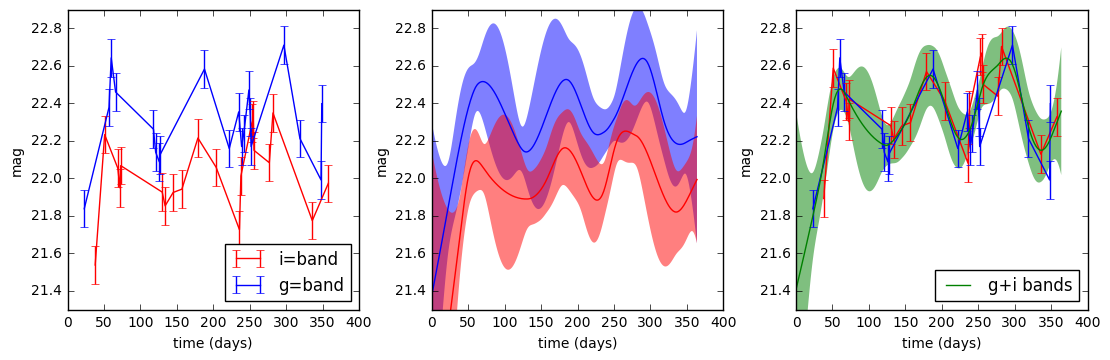

In [13]:
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25, bottom=0.15, top=0.9)
ax1 = fig.add_subplot(131)
ax1.errorbar(t[i_indices],imag[i_indices],dy,c='r', label='i=band')
ax1.errorbar(t[g_indices],gmag[g_indices],dy,c='b', label='g=band')
ax1.set_xlabel('time (days)')
ax1.set_ylabel('mag')
ax1.legend(loc='lower right')
ax1.set_ylim([21.3,22.9])

ax2 = fig.add_subplot(132)
ax2.plot(t_fit, g_pred, 'b-')
ax2.fill(np.concatenate([t_fit, t_fit[::-1]]), np.concatenate([g_pred - 1.9600 * g_err,
        (g_pred + 1.9600 * g_err)[::-1]]), alpha=.5, fc='b', ec='None')
ax2.plot(t_fit, i_pred, 'r-')
ax2.fill(np.concatenate([t_fit, t_fit[::-1]]), np.concatenate([i_pred - 1.9600 * i_err, 
        (i_pred + 1.9600 * i_err)[::-1]]), alpha=.5, fc='r', ec='None')
ax2.set_xlabel('time (days)')
ax2.set_ylabel('mag')
ax2.set_ylim([21.3,22.9])

ax3 = fig.add_subplot(133)
ax3.errorbar(t[i_indices],imag2[i_indices],dy,c='r')
ax3.errorbar(t[g_indices],gmag[g_indices],dy,c='b')
#ax3.plot(t[both_indices[p]],both_mags[p],c='g')
ax3.plot(t_fit, y_pred, 'g-', label='g+i bands')
ax3.fill(np.concatenate([t_fit, t_fit[::-1]]), np.concatenate([y_pred - 1.9600 * y_err,
        (y_pred + 1.9600 * y_err)[::-1]]), alpha=.5, fc='g', ec='None')
ax3.set_xlabel('time (days)')
ax3.set_ylabel('mag')
ax3.set_ylim([21.3,22.9])
ax3.legend(loc='lower right')
plt.savefig('lcmerge.pdf')
